<a id="1"></a>
# Including Libraries

Install some libraries if necessary and import everything that is needed

In [ ]:
# !pip install librosa 

In [ ]:
# Display graphs in line
%matplotlib inline

# Import Functions
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np 
np.random.seed(42)

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
from tqdm import tqdm # install ipywidgets to address warning

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import os
import random

# Suppress read write warnings
import warnings
warnings.filterwarnings('ignore')

#Set the Device to do training on
device = "cuda" if torch.cuda.is_available() else "cpu"

<a id="2"></a>
# Including the Datasets

A path needs to be provided to the main directory. Inside this directory should be a list of folders with Emotions. Each folder contains the audio files ot load

In [24]:
import pandas as pd
import numpy as np
import os
Crema_Path='data/Crema/'
Ravdess_Path='data/Ravdess/audio_speech_actors_01-24'
Savee_Path='data/Savee/' 
Tess_Path='data/Tess/'

class DataSetLoader:
    def __init__(self,data_set_name='All'):
        self.data_set_name = data_set_name
        self.selected_data_set = None
        if self.data_set_name == 'Crema':
            self.selected_data_set = Crema()
        elif self.data_set_name == 'Ravdess':
            self.selected_data_set = Ravdess()
        elif self.data_set_name == 'Savee':
            self.selected_data_set = Savee()
        elif self.data_set_name == 'Tess':
            self.selected_data_set = Tess()
        
        
    def load_data(self):
        if self.data_set_name == 'All':
            crema = Crema()
            ravdess = Ravdess()
            savee = Savee()
            tess = Tess()
            crema_df = crema.load_data()
            ravdess_df = ravdess.load_data()
            savee_df = savee.load_data()
            tess_df = tess.load_data()
            data_set = pd.concat([crema_df,ravdess_df,savee_df,tess_df],ignore_index=True)
            return data_set
        else:
            return self.selected_data_set.load_data()
    
    def get_data_set_name(self):
        return self.data_set_name

class Crema:
    def load_data(self):
        crema=[]
        for wav in os.listdir(Crema_Path):
            emotion=wav.partition(".wav")[0].split('_')
            if emotion[2]=='SAD':
                crema.append(('sad',Crema_Path+'/'+wav))
            elif emotion[2]=='ANG':
                crema.append(('angry',Crema_Path+'/'+wav))
            elif emotion[2]=='DIS':
                crema.append(('disgust',Crema_Path+'/'+wav))
            elif emotion[2]=='FEA':
                crema.append(('fear',Crema_Path+'/'+wav))
            elif emotion[2]=='HAP':
                crema.append(('happy',Crema_Path+'/'+wav))
            elif emotion[2]=='NEU':
                crema.append(('neutral',Crema_Path+'/'+wav))
            else:
                crema.append(('unknown',Crema_Path+'/'+wav))
        Crema_df=pd.DataFrame.from_dict(crema)
        Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Crema_df['Emotion'].unique()
        return Crema_df
    
class Ravdess:
    def load_data(self):
        ravdess=[]
        for directory in os.listdir(Ravdess_Path):
            actors=os.listdir(os.path.join(Ravdess_Path,directory))
            for wav in actors:
                emotion=wav.partition('.wav')[0].split('-')
                emotion_number=int(emotion[2])
                ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
        Ravdess_df=pd.DataFrame.from_dict(ravdess)
        Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
        Ravdess_df.head()
        Ravdess_df['Emotion'].unique()
        return Ravdess_df


class Savee:
    def load_data(self):
        import re
        savee=[]
        for wav in os.listdir(Savee_Path):
            emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
            emotion=re.split(r'[0-9]',emo)[0]
            if emotion=='a':
                savee.append(('angry',Savee_Path+'/'+wav))
            elif emotion=='d':
                savee.append(('disgust',Savee_Path+'/'+wav))
            elif emotion=='f':
                savee.append(('fear',Savee_Path+'/'+wav))
            elif emotion=='h':
                savee.append(('happy',Savee_Path+'/'+wav))
            elif emotion=='n':
                savee.append(('neutral',Savee_Path+'/'+wav))
            elif emotion=='sa':
                savee.append(('sad',Savee_Path+'/'+wav))
            elif emotion=='su':
                savee.append(('surprise',Savee_Path+'/'+wav))
        Savee_df=pd.DataFrame.from_dict(savee)
        Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Savee_df.head()
        Savee_df['Emotion'].unique()
        return Savee_df

class Tess:
    def load_data(self):
        tess=[]
        for directory in os.listdir(Tess_Path):
            for wav in os.listdir(os.path.join(Tess_Path,directory)):
                emotion=wav.partition('.wav')[0].split('_')
                if emotion[2]=='ps':
                    tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
                else:
                    tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
        Tess_df=pd.DataFrame.from_dict(tess)
        Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Tess_df.head()
        return Tess_df

<a id="3"></a>
# Data Analyze

In [33]:
# Convert the dataframe to a csv so it doesn't need to be recreated every time
main_path='main_df.csv'
main_df=DataSetLoader('Tess').load_data()
main_df.to_csv(main_path,index=False)

In [34]:
main_df.head(15)

,Emotion,File_Path
0,angry,data/Tess/OAF_angry\OAF_back_angry.wav
1,angry,data/Tess/OAF_angry\OAF_bar_angry.wav
2,angry,data/Tess/OAF_angry\OAF_base_angry.wav
3,angry,data/Tess/OAF_angry\OAF_bath_angry.wav
4,angry,data/Tess/OAF_angry\OAF_bean_angry.wav
5,angry,data/Tess/OAF_angry\OAF_beg_angry.wav
6,angry,data/Tess/OAF_angry\OAF_bite_angry.wav
7,angry,data/Tess/OAF_angry\OAF_boat_angry.wav
8,angry,data/Tess/OAF_angry\OAF_bone_angry.wav
9,angry,data/Tess/OAF_angry\OAF_book_angry.wav


In [35]:
main_df.tail(15)

,Emotion,File_Path
2785,sad,data/Tess/YAF_sad\YAF_walk_sad.wav
2786,sad,data/Tess/YAF_sad\YAF_wash_sad.wav
2787,sad,data/Tess/YAF_sad\YAF_week_sad.wav
2788,sad,data/Tess/YAF_sad\YAF_wheat_sad.wav
2789,sad,data/Tess/YAF_sad\YAF_when_sad.wav
2790,sad,data/Tess/YAF_sad\YAF_which_sad.wav
2791,sad,data/Tess/YAF_sad\YAF_whip_sad.wav
2792,sad,data/Tess/YAF_sad\YAF_white_sad.wav
2793,sad,data/Tess/YAF_sad\YAF_wife_sad.wav
2794,sad,data/Tess/YAF_sad\YAF_wire_sad.wav


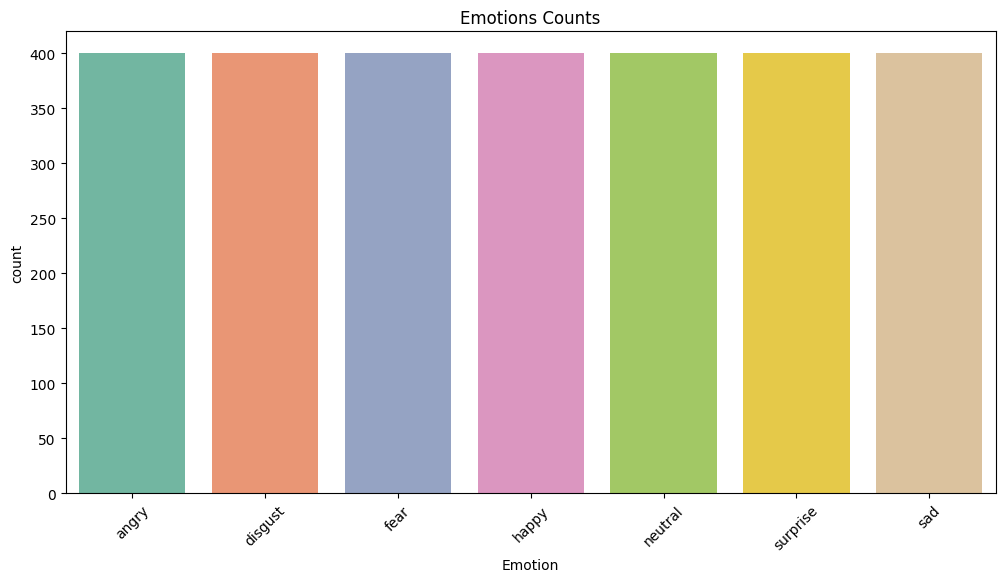

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [37]:
emotion_names=main_df['Emotion'].unique()

In [38]:
# Setup variable for further displays
emotion_names=main_df['Emotion'].unique()
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}


#### Evaluate Distribution

Plot a histogram of the labels. The data is relatively balanced but the surprised class is lacking. We will fix that later during augmentation after loading the audio from the files

[Text(0, 0, 'angry'),
 Text(1, 0, 'disgust'),
 Text(2, 0, 'fear'),
 Text(3, 0, 'happy'),
 Text(4, 0, 'neutral'),
 Text(5, 0, 'surprise'),
 Text(6, 0, 'sad')]

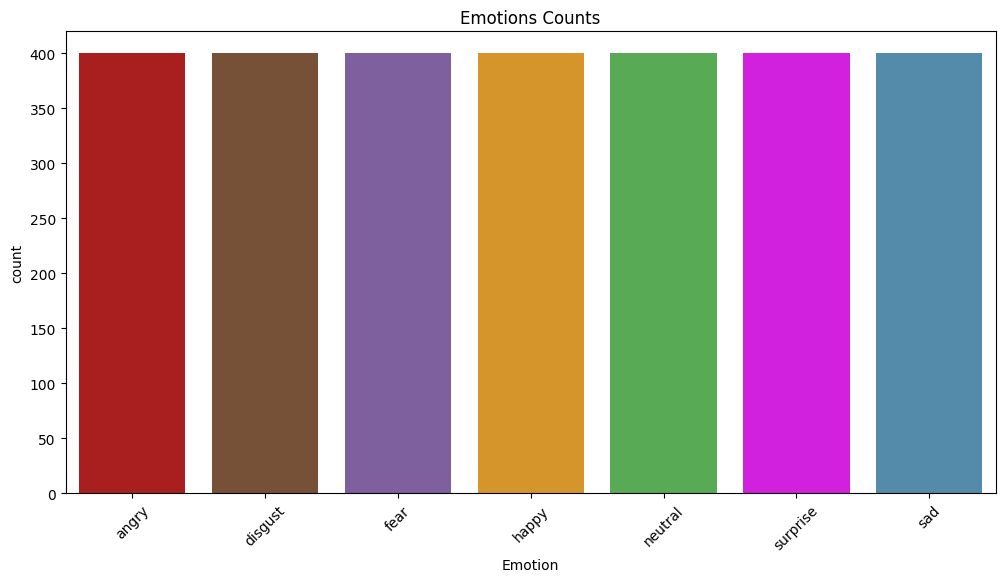

In [39]:
# Evaluate the distribution of the data
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette=colors)
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)

In [40]:
#Make helper functions to display audio files
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

In [41]:
# Take a path from each emotion and display the wave form and spectogram
audio_path={}
for emotion in emotion_names:
    path=main_df[main_df['Emotion']==emotion]['File_Path'].iloc[0]
    audio_path[emotion]=path

for emotion,path in audio_path.items():
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)

# Create a function to extract features from the audio files

NameError: name 'librosa' is not defined

Setup cells to listen to the samples of audio files

In [ ]:
emotion_type = 'Happy'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Sad'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Fearful'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Neutral'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Suprised' #must use 'Suprised' due to typo

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Disgusted'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

In [ ]:
emotion_type = 'Angry' 

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

<a id="7"></a>
## Audio Augmentation and Feature Extraction

Start by creating a class that loads audio files and augments them. 

In [ ]:
# Create a helper class to load audio files. 
# This can be used to load all the csv files in a dataframe and return the audio features and lables
class AudioLoader:

	# Set parameters to work with librosa's functions 
	def __init__(self, frame_length=2048, hop_length=512):
		self.frame_length=frame_length 
		self.hop_length=hop_length

	# Extract relevant features from the audio files and returns them
	def extract_features(self, data,sr,frame_length=2048,hop_length=512):
		result=np.array([])

		# Extract ZCR, RMS and MFCC, using librosa's functions
		zcr=np.squeeze(librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length))
		rmse=np.squeeze(librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length))
		mfcc=librosa.feature.mfcc(y=data,sr=sr)
		mfcc=np.ravel(mfcc.T)
		
		result=np.hstack((result,
						zcr,
						rmse,
						mfcc,
						))
		return result
	
	
	def load(self, df, base_file_path, label_column = "Emotion"):

		# Load the datafiles into audio Files
		X, Y = [], []

		# Load all the base data and split it into feature/columns
		print("Loading data...")
		for _, row  in tqdm(df.iterrows(), total=df.shape[0]):
			path = base_file_path + row[label_column] + "/" + row["File"]
			data,sr=librosa.load(path,duration=2.5, offset=0.6)
			aud=self.extract_features(data,sr)
			audio=np.array(aud)

			X.append(audio)
			Y.append(row[label_column])

		return X, Y

In [ ]:
# Create a helper class to balance the data labels in the data set by augmenting the rows wihch are lacking
class DataBalancer:
    
	# Define Data Augmentation Functions for the class
	def add_noise(self, data,random=False,rate=0.035,threshold=0.075):
		if random:
			rate=np.random.random()*threshold
		noise=rate*np.random.uniform()*np.amax(data)
		augmented_data=data+noise*np.random.normal(size=data.shape[0])
		return augmented_data
	
	def shifting(self, data,rate=1000):
		augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
		augmented_data=np.roll(data,augmented_data)
		return augmented_data

	def pitching(self, data,sr,pitch_factor=0.7,random=False):
		if random:
			pitch_factor=np.random.random() * pitch_factor
		return librosa.effects.pitch_shift(data,sr=sr,n_steps=pitch_factor)

	def streching(self, data,rate=0.8):
		return librosa.effects.time_stretch(data,rate=rate)
	

	
	def load_balanced(self, df, base_file_path, label_column = "Emotion", max_expansion = 1.5):

		# Load the base data
		loader = AudioLoader()
		X, Y = loader.load(df, base_file_path, label_column = label_column)

		
		# Figure out how big the dataset is and should be
		counts = df[label_column].value_counts()
		new_label_count = int(max_expansion * max(counts))

		# Loop over the labels and add enough columns for it to be balanced
		print("Balancing the data set")
		for emotion in tqdm(df[label_column].unique(), total = df[label_column].nunique()):

			# Figure out how many rows to add
			current_count = counts[emotion]
			needed_rows  = new_label_count - current_count

			# Compile the list of random files to augment to bring up the sample count to a balanced set
			rows_to_augment = df[df[label_column] == emotion].iloc[:1]
			while needed_rows > 0 :
				rows_to_augment = pd.concat([rows_to_augment, df[df[label_column] == emotion].sample(n = min(needed_rows, current_count))], axis = 0)
				needed_rows -= current_count
			
			# Loop over the rows, load the audio file, augment it and then use the loader to extract it features
			print("Augmenting the data set")
			for _, row in tqdm(rows_to_augment.iterrows(), total = rows_to_augment.shape[0]):

				path = base_file_path + row[label_column] + "/" + row["File"]
				data, sr = librosa.load(path,duration=2.5, offset=0.6)

				option = random.randint(1, 4)

				# Apply a random feature augmentation to data
				if option == 1:
					aug_audio=self.add_noise(data,random=True)
				elif option == 2:
					aug_audio=self.pitching(data,sr,random=True)	
				elif option == 3:
					aug_audio=self.streching(data)
				elif option == 4:
					aug_audio=self.shifting(data)

				aud=loader.extract_features(aug_audio,sr)
				audio=np.array(aud)

				X.append(audio)
				Y.append(row[label_column])

		return X, Y
	
db = DataBalancer()
X_augmented, Y_augmented = db.load_balanced(main_df, main_Path)

In [ ]:
# Save extracted audio to a csv since it take a while to generate
extract=pd.DataFrame(X_augmented)
extract['Emotion']=Y_augmented
extract.to_csv("processed_data.csv",index=False)

### Check that augmented dataset is in fact balanced

Looks like it is evenly balanced now thanks to data augmentation

In [ ]:
# Check that augmented dataset is in fact balanced
plt.figure(figsize=(12,6))
plt.title('Augmented Emotions Counts')
emotions=sns.countplot(x='Emotion',data=extract,palette=colors)
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)


In [ ]:
# check info() on augmented dataset
extract.info()

In [ ]:
#Load one of the files to show how the augmentations work
ex_emotion_type = "Happy"
ex_aug_file_path = audio_path[ex_emotion_type]
data,sr=librosa.load(ex_aug_file_path)

<a id="4"></a>
## Check data Augmentation Behaviour
### Original Audio

In [ ]:
plt.figure(figsize=(12,5))
librosa.display.waveshow(data,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(ex_aug_file_path)

<a id="8"></a>
### Noised Audio

In [ ]:
noised_audio=db.add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(noised_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Streched Audio

In [ ]:
stretched_audio=db.streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(stretched_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

In [ ]:
shifted_audio=db.shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(shifted_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

In [ ]:
pitched_audio=db.pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(pitched_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(pitched_audio,rate=sr)

<a id="14"></a>
# Processing

<a id="15"></a>
### Including Analyzed Audio Features

In [ ]:
# Read back in the proccessed data
df=pd.read_csv("processed_data.csv")
df.shape
df=df.sample(frac=1).reset_index(drop=True)
print(df.shape)


In [ ]:
df=df.fillna(0)
print(df.isna().any())
df.shape

<a id="16"></a>
# Processing Analyzed Data for Training

In [ ]:
# Split dataframe into data and labels
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

# Convert emotion label to an index
indexes = {'Disgusted':0,'Happy':1,'Sad':2,'Neutral':3,'Fearful':4,'Angry':5,'Suprised':6}
Y = Y.map(indexes)

# Convert the labels into a catagorical columns
lb=LabelEncoder()
Y = torch.tensor(Y)
Y = lb.fit_transform(Y)
Y = torch.nn.functional.one_hot(torch.tensor(Y)).float()
Y.shape

<a id="17"></a>
## Train, Test and Validation Spliting

In [ ]:
# Split off a test set for the final validation (balanced dataset, so no need to 'stratify')
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True, stratify=None)

# Split the training set further into a training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True, stratify=None)

print(f"Train: X:{X_train.shape}, y: {y_train.shape}")
print(f"Validation: X:{X_val.shape}, y: {y_val.shape}")
print(f"Test: X:{X_test.shape}, y: {y_test.shape}")

## Normalize the data using Standard Scaler

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

In [ ]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

<a id="19"></a>
# Train the model

## Setup Pytorch Neural Network

In [ ]:
# Define the Convolutional Neural Network to train the model with in a class
class AudioModel(nn.Module):
    def __init__(self):
        super(AudioModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(in_features=128*93, out_features=512)
        self.bn6 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(in_features=512, out_features=7)
        
    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))
        x = self.pool5(self.bn5(F.relu(self.conv5(x))))
        x = x.flatten(start_dim=1)
        x = self.bn6(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        return x

audio_model = AudioModel()
audio_model

<a id="18"></a>
## Tuning for Training

In [ ]:
#Define an early stopper class to use during training

class EarlyStopper():
    def __init__(self, patience: int = 3):
        self.best_val = +np.inf
        self.current_val = +np.inf
        self.patience = patience
        self.steps_since_last_best = 0
        
    def __call__(self, val) -> bool:
        self.current_val = val
        self._update_best()
        if self.steps_since_last_best == self.patience:
            return True
        else:
            return False
        
    def _update_best(self):
        if self.current_val < self.best_val:
            tqdm.write(f"New best: {self.current_val:.4f}")
            self.best_val=self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best+=1

# Pick an optimizer and use it to define a scheduler
optim = torch.optim.Adam(params=audio_model.parameters())

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)

### Initialize a dataloader and create dataloaders for train, test, split

In [ ]:
def get_data_loader(x,y,bs):
    # Permute np.array from NLC TO NCL
    x = torch.permute(torch.Tensor(x), dims=(0, 2, 1))
    y = torch.Tensor(y)
    return DataLoader(
        TensorDataset(x, y),
        batch_size=bs
    )

# Check the device and set datasize accordingly
if device == "cpu":
    # Small dataset for cpu running to setup data
    length = 100
    train_loader = get_data_loader(X_train[:length, :], y_train[:length, :], 8)
    val_loader = get_data_loader(X_val[:length, :], y_val[:length, :], 8)
    test_loader = get_data_loader(X_test[:length, :], y_test[:length, :], 8)
else:
    # Run full datasets on GPU for final training
    train_loader = get_data_loader(X_train, y_train, 8)
    val_loader = get_data_loader(X_val, y_val, 8)
    test_loader = get_data_loader(X_test, y_test, 8)

### Define functions for training and validating the model

In [ ]:
#
# TODO: populate the history dict for plots below
# train_val_loss_acc_hist_avgs = {"epoch":[], "train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
#

# New code to define a model trainer
def train(model, optim, scheduler, criterion, train_loader) -> (float, float):
    device = next(iter(model.parameters())).device
    model.train()
    total_loss = 0
    total_acc = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        total_loss += loss.item()
        total_acc += torch.sum(torch.argmax(y_pred.squeeze(), dim=1) == y).item()
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / (len(train_loader.dataset))
    scheduler.step(avg_loss)
    return avg_loss, avg_acc

@torch.no_grad()
def validate(model, val_loader, criterion) -> (float, float):
    model.eval()
    device = next(iter(audio_model.parameters())).device
    total_loss = 0
    total_acc = 0
    for x,y in val_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.argmax(y_pred.squeeze(), dim=1) == y).item()
    avg_loss = total_loss / len(val_loader)
    avg_acc = total_acc / (len(val_loader.dataset))
    return avg_loss, avg_acc


### Train the model

In [ ]:
model_name = "./best_model.pt" # Path to save best model
epochs = 100 # Number of epochs to run
criterion = nn.CrossEntropyLoss() # Criteria to evaluate performance
early_stopper = EarlyStopper(patience=5)
audio_model.to(device)
train_val_loss_acc_hist_avgs = {"epoch":[], "train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
# Loop over the epochs, train the model, and check if the error is improving
for _ in tqdm(range(epochs)):
    train_acc, train_loss =train(audio_model, optim, lr_scheduler, criterion, train_loader)
    val_acc, val_loss = validate(audio_model, val_loader, criterion)
    train_val_loss_acc_hist_avgs["epoch"].append(_)
    train_val_loss_acc_hist_avgs["train_loss"].append(train_loss)
    train_val_loss_acc_hist_avgs["val_loss"].append(val_loss)
    train_val_loss_acc_hist_avgs["train_acc"].append(train_acc)
    train_val_loss_acc_hist_avgs["val_acc"].append(val_acc)
    if early_stopper(val_loss):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(audio_model, model_name)

# Reload Best Model and Evaluate Performance

In [ ]:

net = torch.load(model_name)
net.eval() # Set the model to evaluation mode prior to testing

In [ ]:
# Calculate how many items it gets right
correct = 0
total = 0

with torch.no_grad():
    for audio, labels in test_loader:

        # Convert if run on a cuda device
        if device != "cpu":
            audio = audio.cuda()
            labels = labels.cuda()

        # Predict the outputs
        outputs = net(audio)
        _, labels = torch.max(labels.data, 1)
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of outputs gottten correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test audio samples: {100 * correct / total:.2f}: %')

<a id="20"></a>
# Analyze The Model Performance

<a id="21"></a>
## Accuracy History Charts

In [ ]:
# create dataframe from the history
df = pd.DataFrame.from_dict(train_val_loss_acc_hist_avgs)
print(df.head())
print(df.tail())

# plot Training Accuracy Data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='train_acc', label='Training Accuracy')

# labels
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()

In [ ]:
# plot the Validation Accuracy data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='val_acc', label='Validation Accuracy')

# labels
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

<a id="22"></a>
## Loss History Charts

In [ ]:
# create dataframe from the history
df = pd.DataFrame.from_dict(train_val_loss_acc_hist_avgs)

# plot the Training Loss data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='train_loss', label='Training Loss')

# labels
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
# plot the Validation Loss data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='val_loss', label='Validation Loss')

# labels
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

<a id="24"></a>
# Testing Model and Test Results

<a id="25"></a>
## Confusion Matrix

In [ ]:
labels = np.array([0, 1, 2, 1, 6, 6, 0, 1, 2, 2, 0, 3, 3, 2, 5, 4, 5])
predicted = np.array([0, 1, 1, 1, 6, 4, 0, 2, 2, 1, 0, 1, 3, 2, 0, 5, 5])
print(emotion_names)

conf=confusion_matrix(y_true=labels,y_pred=predicted)
print(conf)

cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')

ax.set_title(f'Confusion Matrix for Emotions Audio Model')
ax.set_xlabel("Predicted Emotion")
ax.set_ylabel("Actual Emotion")
plt.show()

In [ ]:
cr = classification_report(y_true=labels, y_pred=predicted, target_names=emotion_names)
print("Classification Report:\n", cr)

## Live Data Demo

In [ ]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import time

fs = 16000 
seconds = 3  
path="test.wav"
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  
sf.write(path, myrecording, fs)  

sd.play(myrecording, fs)
time.sleep(seconds)
sd.stop()

audio_loader = AudioLoader()
data,sr=librosa.load(path,duration=2.5, offset=0.6)
aud=audio_loader.extract_features(data,sr)
audio=np.array(aud)

model = torch.load(model_name)


enmoji={'disgust':'😷','happy':'😃','sad':'😢','neutral':'😐','fear':'😨','angry':'😠','surprise':'😲'}

with torch.no_grad():
    audio = torch.from_numpy(audio).float().to(device)
    outputs = model(audio)
    _, labels = torch.max(labels.data, 1)
    _, predicted = torch.max(outputs.data, 1)
    print(f'Predicted Emotion: {emotion_names[predicted]} {enmoji[emotion_names[predicted]]}')

    


